Problem Statement: The task is to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

MULTINOMIAL CLASSIFICATION (normal or DOS or PROBE or R2L or U2R)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import seaborn as sns
# import statsmodels.formula.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn import datasets
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [5]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [7]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [8]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90382 entries, 0 to 90381
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     90382 non-null  int64  
 1   protocol_type                90382 non-null  object 
 2   service                      90382 non-null  object 
 3   flag                         90382 non-null  object 
 4   src_bytes                    90382 non-null  int64  
 5   dst_bytes                    90382 non-null  int64  
 6   land                         90382 non-null  int64  
 7   wrong_fragment               90382 non-null  int64  
 8   urgent                       90382 non-null  int64  
 9   hot                          90382 non-null  int64  
 10  num_failed_logins            90382 non-null  int64  
 11  logged_in                    90382 non-null  int64  
 12  num_compromised              90382 non-null  int64  
 13  root_shell      

In [10]:
print("PROTOCOL TYPES", train["protocol_type"].unique(), "\n")
print("SERVICE TYPES", train["service"].unique(), "\n")
print("FLAG TYPES", train["flag"].unique(), "\n")

PROTOCOL TYPES ['tcp' 'udp' 'icmp'] 

SERVICE TYPES ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest'] 

FLAG TYPES ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH'] 



In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,90382.0,284.408024,2.582158e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,90382.0,40717.245989,5.130781e+06,0.0,0.00,44.00,276.00,1.167519e+09
dst_bytes,90382.0,21955.324368,4.556693e+06,0.0,0.00,0.00,511.00,1.309937e+09
land,90382.0,0.000210,1.449748e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,90382.0,0.022272,2.516619e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,90382.0,0.000089,1.411202e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,90382.0,0.194939,2.087243e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,90382.0,0.001140,4.398805e-02,0.0,0.00,0.00,0.00,4.000000e+00
logged_in,90382.0,0.395234,4.889035e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,90382.0,0.309221,2.754258e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [12]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', ' num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'last_flag'],
      dtype='object')

In [13]:
# Adding classification label in training samples
train.loc[train.attack == "normal", "attack_class"] = 0

train.loc[
    (train.attack == "back")
    | (train.attack == "land")
    | (train.attack == "pod")
    | (train.attack == "neptune")
    | (train.attack == "smurf")
    | (train.attack == "teardrop")
    | (train.attack == "apache2")
    | (train.attack == "udpstorm")
    | (train.attack == "processtable")
    | (train.attack == "worm")
    | (train.attack == "mailbomb"),
    "attack_class",
] = 1  # 1 = DOS

train.loc[
    (train.attack == "satan")
    | (train.attack == "ipsweep")
    | (train.attack == "nmap")
    | (train.attack == "portsweep")
    | (train.attack == "mscan")
    | (train.attack == "saint"),
    "attack_class",
] = 2  # 2 = PROBE

train.loc[
    (train.attack == "guess_passwd")
    | (train.attack == "ftp_write")
    | (train.attack == "imap")
    | (train.attack == "phf")
    | (train.attack == "multihop")
    | (train.attack == "warezmaster")
    | (train.attack == "warezclient")
    | (train.attack == "spy")
    | (train.attack == "xlock")
    | (train.attack == "xsnoop")
    | (train.attack == "snmpguess")
    | (train.attack == "snmpgetattack")
    | (train.attack == "httptunnel")
    | (train.attack == "sendmail")
    | (train.attack == "named"),
    "attack_class",
] = 3  # 3 = R2L

train.loc[
    (train.attack == "buffer_overflow")
    | (train.attack == "loadmodule")
    | (train.attack == "rootkit")
    | (train.attack == "perl")
    | (train.attack == "sqlattack")
    | (train.attack == "xterm")
    | (train.attack == "ps"),
    "attack_class",
] = 4  # 4 = U2L

In [14]:
# Adding classification label in testing samples
test.loc[test.attack == "normal", "attack_class"] = 0

test.loc[
    (test.attack == "back")
    | (test.attack == "land")
    | (test.attack == "pod")
    | (test.attack == "neptune")
    | (test.attack == "smurf")
    | (test.attack == "teardrop")
    | (test.attack == "apache2")
    | (test.attack == "udpstorm")
    | (test.attack == "processtable")
    | (test.attack == "worm")
    | (test.attack == "mailbomb"),
    "attack_class",
] = 1  # 1 = DOS

test.loc[
    (test.attack == "satan")
    | (test.attack == "ipsweep")
    | (test.attack == "nmap")
    | (test.attack == "portsweep")
    | (test.attack == "mscan")
    | (test.attack == "saint"),
    "attack_class",
] = 2  # 2 = PROBE

test.loc[
    (test.attack == "guess_passwd")
    | (test.attack == "ftp_write")
    | (test.attack == "imap")
    | (test.attack == "phf")
    | (test.attack == "multihop")
    | (test.attack == "warezmaster")
    | (test.attack == "warezclient")
    | (test.attack == "spy")
    | (test.attack == "xlock")
    | (test.attack == "xsnoop")
    | (test.attack == "snmpguess")
    | (test.attack == "snmpgetattack")
    | (test.attack == "httptunnel")
    | (test.attack == "sendmail")
    | (test.attack == "named"),
    "attack_class",
] = 3  # 3 = R2L

test.loc[
    (test.attack == "buffer_overflow")
    | (test.attack == "loadmodule")
    | (test.attack == "rootkit")
    | (test.attack == "perl")
    | (test.attack == "sqlattack")
    | (test.attack == "xterm")
    | (test.attack == "ps"),
    "attack_class",
] = 4  # 4 = U2L

In [15]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train Columns: ", train.columns)
print("Test Columns: ", test.columns)

Train shape: (90382, 44)
Test shape: (22544, 44)
Train Columns:  Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', ' num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'last_flag', 'attack_class'],
      dtype='object')
Test Columns:  Index(['duration', 'protocol_type', 's

BASIC EXPLORATORY DATA ANALYSIS

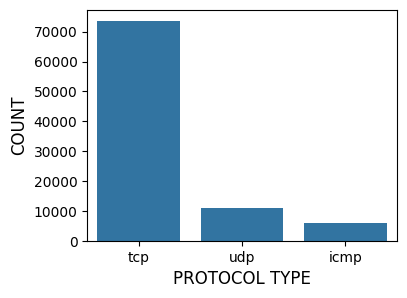

In [16]:
# Protocol type distribution
plt.figure(figsize=(4, 3))
sns.countplot(x="protocol_type", data=train)
plt.xlabel("PROTOCOL TYPE", fontsize=12)
plt.ylabel("COUNT", fontsize=12)
plt.show()

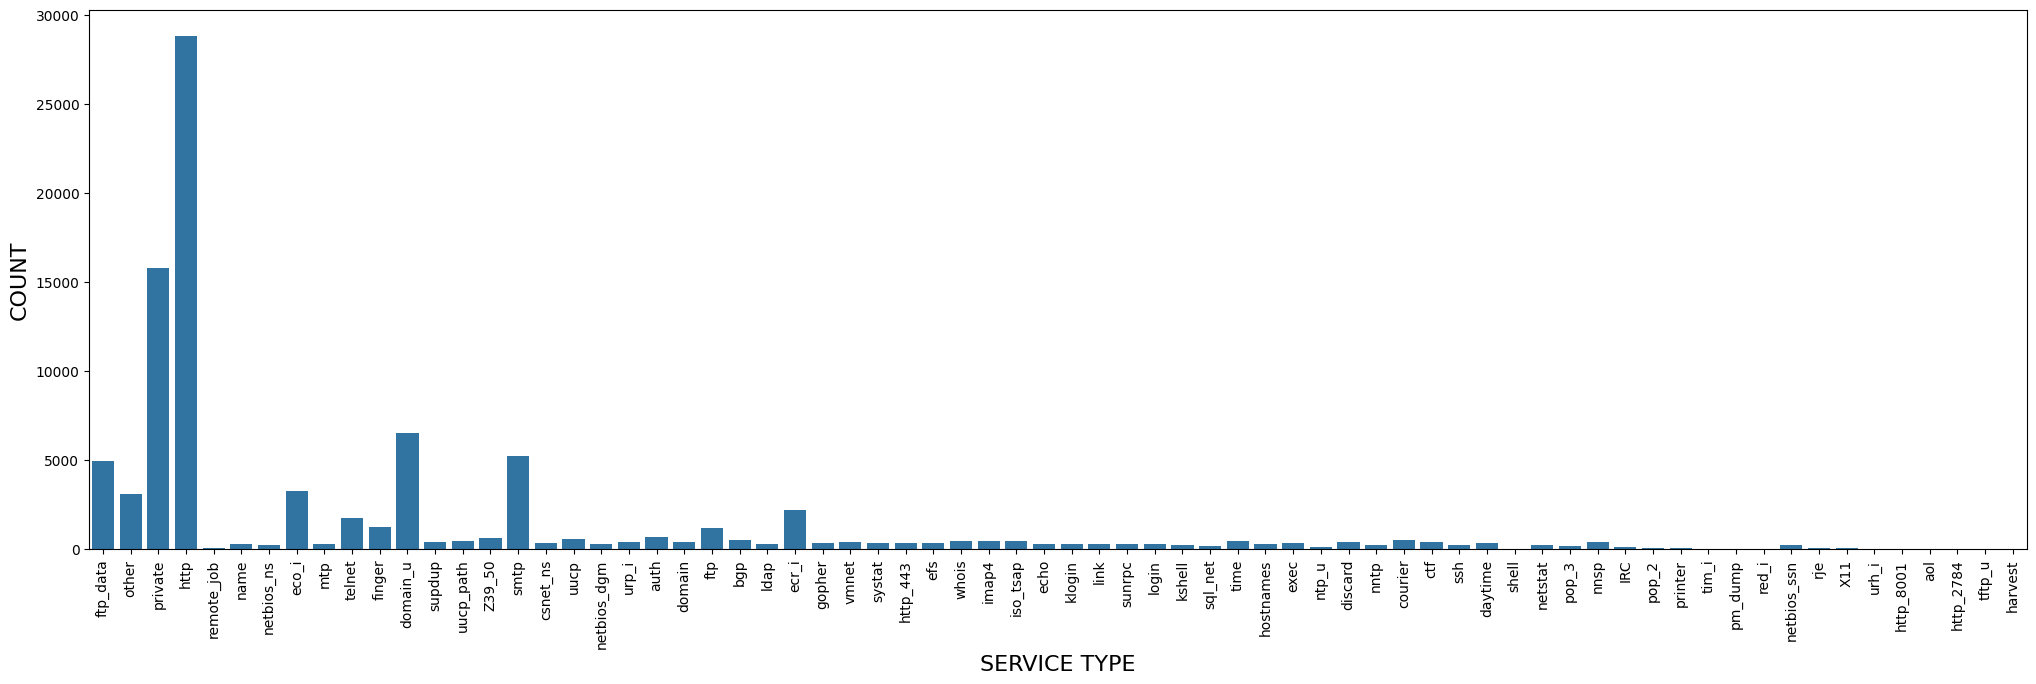

In [17]:
# service distribution
plt.figure(figsize=(25, 7))
sns.countplot(x="service", data=train)
plt.xlabel("SERVICE TYPE", fontsize=16)
plt.ylabel("COUNT", fontsize=16)
plt.xticks(rotation=90)
plt.show()

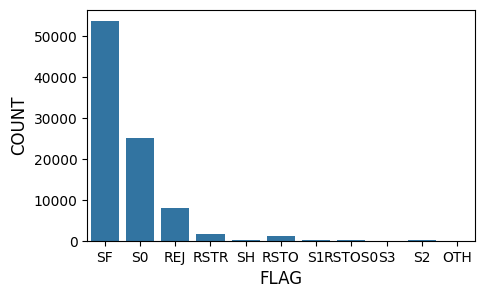

In [18]:
# flag distribution
plt.figure(figsize=(5, 3))
sns.countplot(x="flag", data=train)
plt.xlabel("FLAG", fontsize=12)
plt.ylabel("COUNT", fontsize=12)
plt.show()

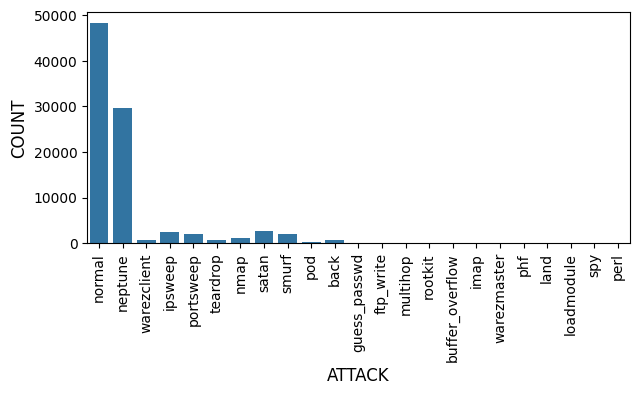

In [19]:
# attack distribution
plt.figure(figsize=(7, 3))
sns.countplot(x="attack", data=train)
plt.xlabel("ATTACK", fontsize=12)
plt.ylabel("COUNT", fontsize=12)
plt.xticks(rotation=90)
plt.show()

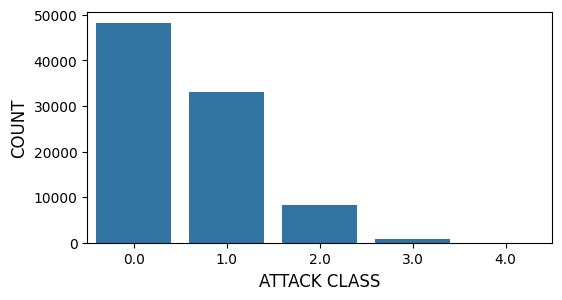

In [20]:
# attack class distribution
plt.figure(figsize=(6, 3))
sns.countplot(x="attack_class", data=train)
plt.xlabel("ATTACK CLASS", fontsize=12)
plt.ylabel("COUNT", fontsize=12)
plt.show()

In [21]:
numeric_columns = train.select_dtypes(include=[float, int]).columns
train.groupby("attack_class")[numeric_columns].mean().T.drop("attack_class")

attack_class,0.0,1.0,2.0,3.0,4.0
duration,170.863724,0.005059,2044.602136,577.278008,83.268293
src_bytes,11213.346273,1175.831743,345803.335934,302448.959889,1033.804878
dst_bytes,4323.965574,169.561998,205270.599736,82342.836791,4206.365854
land,0.000124,0.000394,0.000000,0.000000,0.000000
wrong_fragment,0.000000,0.060983,0.000000,0.000000,0.000000
urgent,0.000145,0.000000,0.000000,0.000000,0.024390
hot,0.214719,0.039868,0.001920,8.103734,1.512195
num_failed_logins,0.001346,0.000000,0.000480,0.045643,0.024390
logged_in,0.709945,0.020843,0.007081,0.919779,0.878049
num_compromised,0.562918,0.019237,0.000720,0.105118,1.341463


In [22]:
numeric_var_names = [
    key
    for key in dict(train.dtypes)
    if dict(train.dtypes)[key] in ["float64", "int64", "float32", "int32"]
]
cat_var_names = [
    key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ["object", "O"]
]
print("Numeric Variable", numeric_var_names)
print("Categorical Variable", cat_var_names)

Numeric Variable ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', ' num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'last_flag', 'attack_class']
Categorical Variable ['protocol_type', 'service', 'flag', 'attack']


In [23]:
train_num = train[numeric_var_names]
test_num = test[numeric_var_names]
train_cat = train[cat_var_names]
test_cat = test[cat_var_names]

In [24]:
# Handling Outliers
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x


train_num = train_num.apply(outlier_capping)

In [25]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(
        df[colname], prefix=colname, drop_first=True, dtype=int
    )
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df


# for c_feature in categorical_features
for c_feature in ["protocol_type", "service", "flag", "attack"]:
    train_cat = create_dummies(train_cat, c_feature)
    test_cat = create_dummies(test_cat, c_feature)
train_cat.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,...,attack_phf,attack_pod,attack_portsweep,attack_rootkit,attack_satan,attack_smurf,attack_spy,attack_teardrop,attack_warezclient,attack_warezmaster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
train = pd.concat([train_num, train_cat], axis=1)
test = pd.concat([test_num, test_cat], axis=1)

In [27]:
correlation = train.corr()
correlation

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,attack_phf,attack_pod,attack_portsweep,attack_rootkit,attack_satan,attack_smurf,attack_spy,attack_teardrop,attack_warezclient,attack_warezmaster
duration,1.000000,0.010375,0.038024,NaN,NaN,NaN,0.017098,NaN,-0.064588,0.066411,...,-0.000768,-0.005311,0.403584,-0.000473,-0.024044,-0.020322,0.000740,-0.011644,0.033769,-0.001511
src_bytes,0.010375,1.000000,0.128693,NaN,NaN,NaN,0.484924,NaN,0.163420,0.597676,...,-0.000919,0.002700,-0.022523,-0.001262,-0.028969,-0.002960,-0.000656,-0.013693,0.046886,-0.001947
dst_bytes,0.038024,0.128693,1.000000,NaN,NaN,NaN,0.148805,NaN,0.420838,0.236225,...,0.010303,-0.013446,-0.053085,0.008147,-0.060386,-0.051452,-0.000176,-0.029478,-0.012215,0.067955
land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wrong_fragment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
attack_smurf,-0.020322,-0.002960,-0.051452,NaN,NaN,NaN,-0.021010,NaN,-0.118304,-0.015018,...,-0.000843,-0.005597,-0.022515,-0.001539,-0.025359,1.000000,-0.000688,-0.012270,-0.012445,-0.001821
attack_spy,0.000740,-0.000656,-0.000176,NaN,NaN,NaN,-0.000675,NaN,0.001008,-0.000483,...,-0.000027,-0.000180,-0.000724,-0.000049,-0.000815,-0.000688,1.000000,-0.000394,-0.000400,-0.000059
attack_teardrop,-0.011644,-0.013693,-0.029478,NaN,NaN,NaN,-0.012038,NaN,-0.067784,-0.008605,...,-0.000483,-0.003207,-0.012901,-0.000882,-0.014530,-0.012270,-0.000394,1.000000,-0.007131,-0.001044
attack_warezclient,0.033769,0.046886,-0.012215,NaN,NaN,NaN,0.228208,NaN,0.105199,-0.008728,...,-0.000490,-0.003252,-0.013085,-0.000895,-0.014737,-0.012445,-0.000400,-0.007131,1.000000,-0.001059


<Axes: >

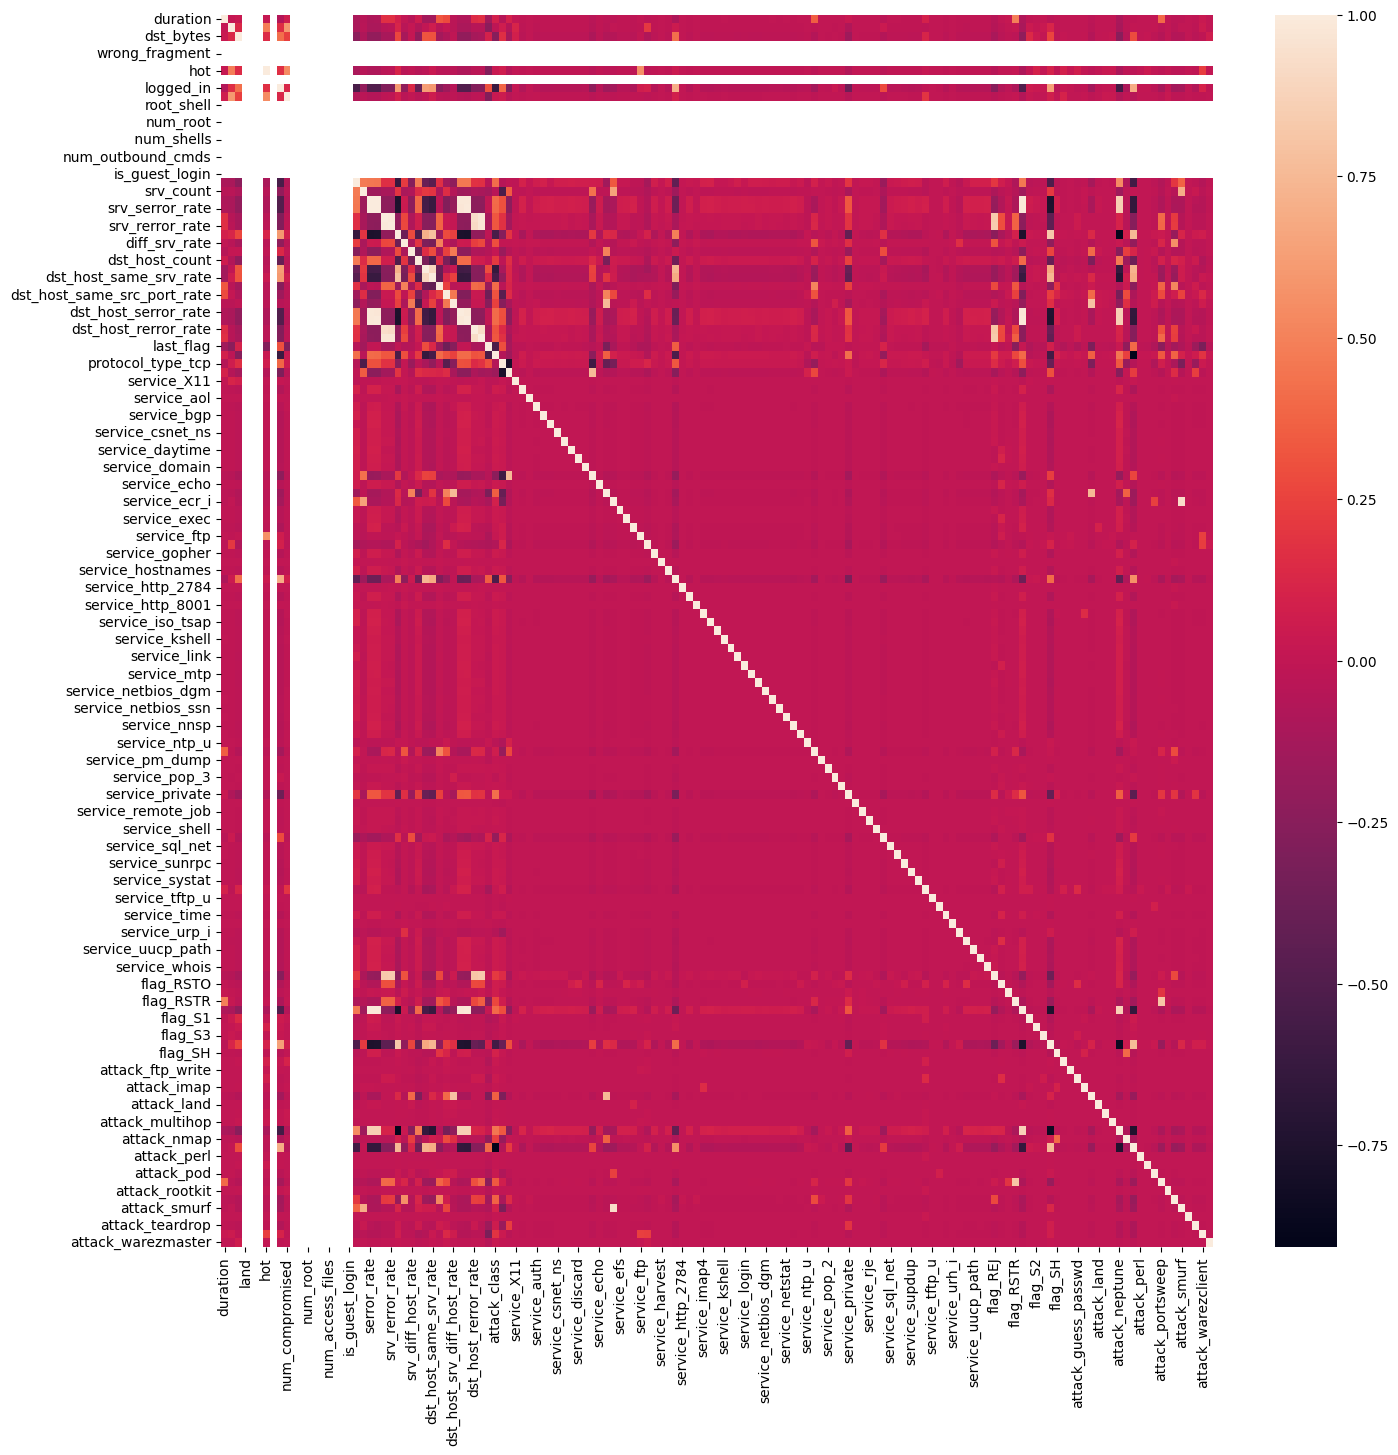

In [28]:
plt.figure(figsize=(16, 16))
sns.heatmap(correlation)

In [29]:
train.columns.values

array(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', ' num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'last_flag',
       'attack_class', 'protocol_type_tcp', 'protocol_type_udp',
       'service_X11', 'service_Z39_50', 'service_aol', 'service_auth',
       'service_bgp', 'service_courier', 'service_csnet_ns',
       'servi

In [30]:
train.drop(
    columns=[
        "land",
        "wrong_fragment",
        "urgent",
        "num_failed_logins",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        " num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "dst_host_rerror_rate",
        "dst_host_serror_rate",
        "dst_host_srv_rerror_rate",
        "dst_host_srv_serror_rate",
        "num_outbound_cmds",
        "srv_rerror_rate",
        "srv_serror_rate",
    ],
    axis=1,
    inplace=True,
)

<Axes: >

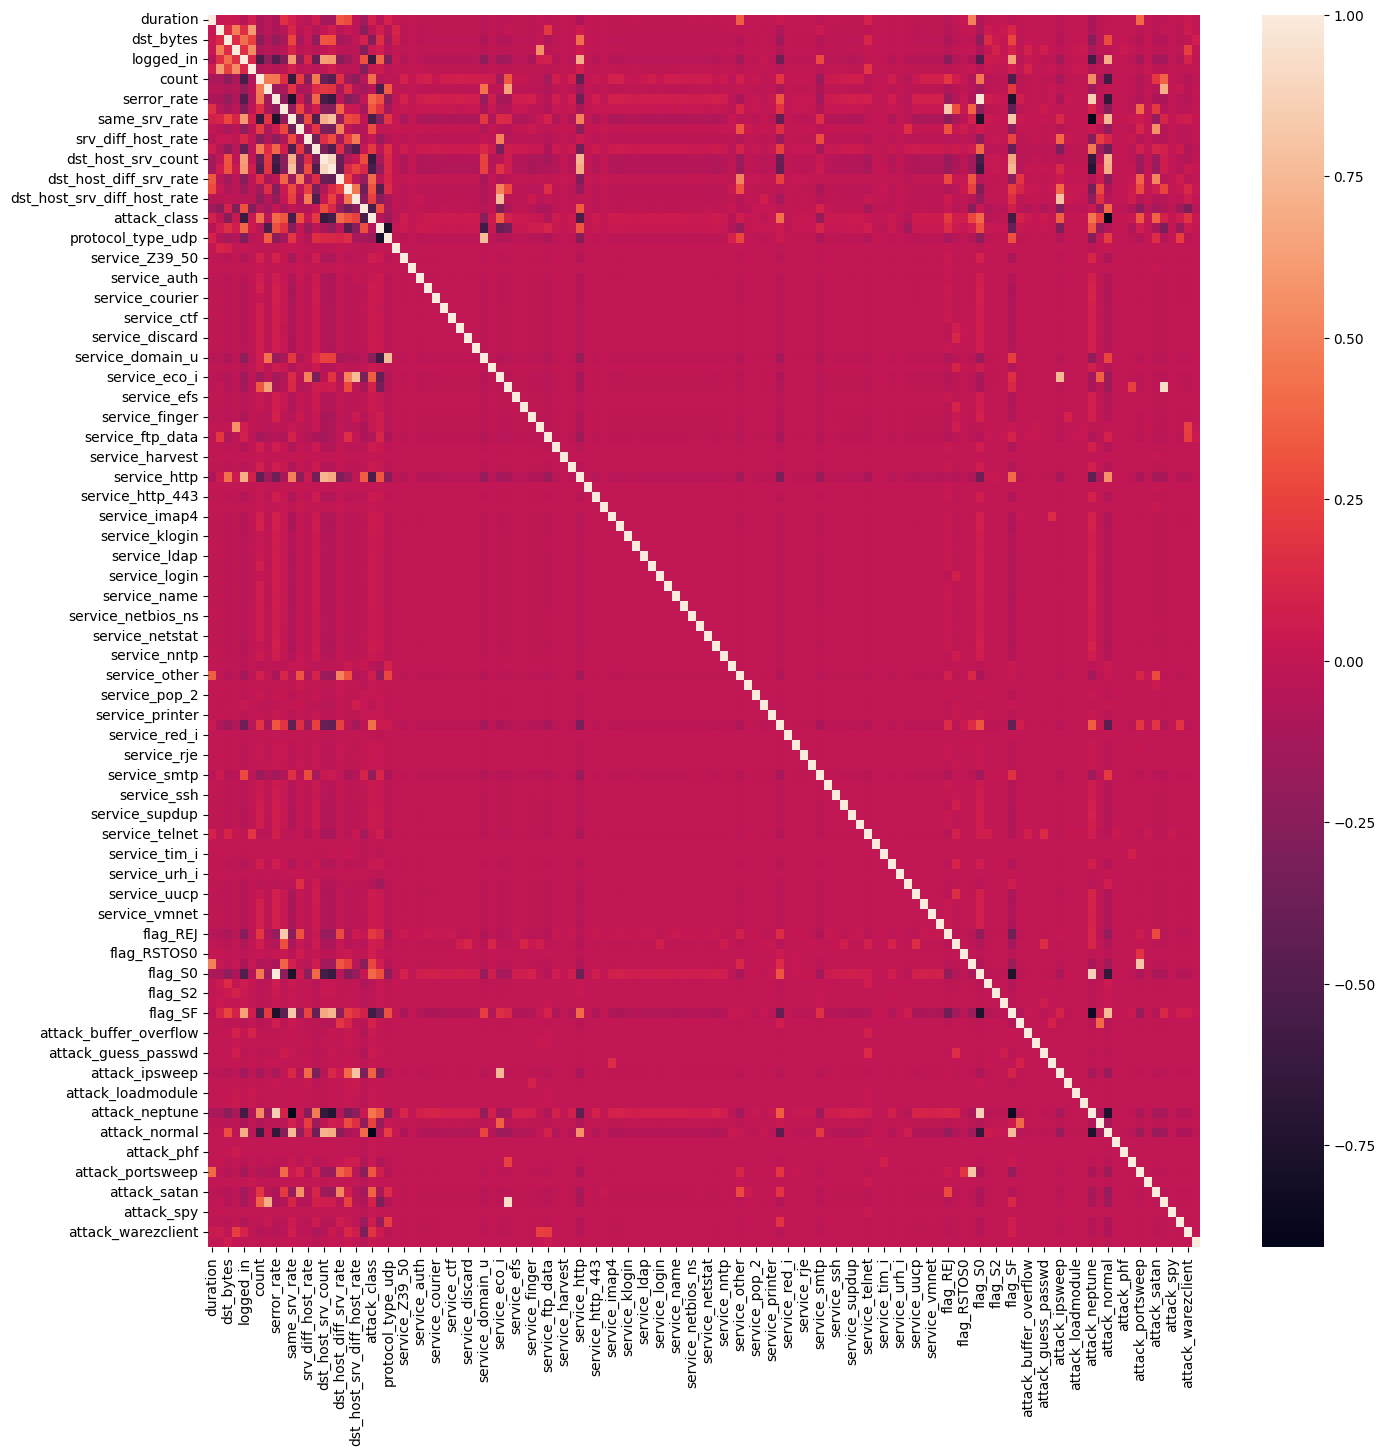

In [31]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr())

In [32]:
X = train[train.columns.difference(["attack_class"])]
X_new = SelectKBest(f_classif, k=15).fit(X, train["attack_class"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [33]:
X_new.get_support()

array([False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [34]:
KBest_features = X.columns[X_new.get_support()]
KBest_features

Index(['attack_neptune', 'attack_normal', 'attack_satan', 'count',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_same_srv_rate', 'dst_host_srv_count', 'flag_S0', 'flag_SF',
       'last_flag', 'logged_in', 'same_srv_rate', 'serror_rate',
       'service_http'],
      dtype='object')

In [35]:
features = [
    "attack_neptune",
    "attack_normal",
    "attack_satan",
    "count",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_same_srv_rate",
    "dst_host_srv_count",
    "flag_S0",
    "flag_SF",
    "last_flag",
    "logged_in",
    "same_srv_rate",
    "serror_rate",
    "service_http",
]
X_train = train[features]
y_train = train["attack_class"]
X_test = test[features]
y_test = test["attack_class"]

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

StandardScaler()

In [37]:
# Now apply the transformations to the data:
train_X = scaler.transform(X_train)
test_X = scaler.transform(X_test)

In [38]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30))
mlp.fit(train_X, y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [39]:
y_pred = mlp.predict(test_X)
y_pred

array([1., 1., 0., ..., 1., 0., 2.])

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_pred))

[[9711    0    0    0    0]
 [  43 6825  592    0    0]
 [   0  277 2144    0    0]
 [ 283  500 2102    0    0]
 [   0    0   67    0    0]]


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      9711
         1.0       0.90      0.91      0.91      7460
         2.0       0.44      0.89      0.59      2421
         3.0       0.00      0.00      0.00      2885
         4.0       0.00      0.00      0.00        67

    accuracy                           0.83     22544
   macro avg       0.46      0.56      0.50     22544
weighted avg       0.76      0.83      0.79     22544



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
mlp.coefs_

[array([[ 2.17226561e-01,  2.63327347e-01,  2.30812201e-01,
         -2.56391938e-01,  4.09155365e-01, -1.29982205e-01,
         -4.31121072e-01,  5.00233194e-01,  8.90933127e-02,
          5.08450714e-01,  4.03914542e-02, -2.38114004e-01,
         -4.95918154e-01, -3.83593865e-01, -2.49979588e-01,
         -6.84359716e-02,  9.09511973e-02, -1.31704222e-02,
          3.47312333e-01, -4.18130517e-02,  9.17322307e-02,
          4.33836069e-01,  2.09920615e-01,  3.27019901e-01,
          2.80868826e-01,  1.13595087e-01,  1.33634976e-01,
         -1.22710576e-01, -3.27962593e-01, -2.13877321e-01],
        [ 1.26368319e-02,  5.74273265e-02,  4.22923950e-01,
         -3.70495312e-02, -2.76691178e-01, -4.92237055e-01,
         -1.80761607e-01,  1.93784362e-01, -3.08681704e-01,
         -4.11767682e-01,  3.52521434e-01,  6.97302365e-02,
         -3.32575533e-02,  5.83188082e-01,  6.53015612e-01,
         -1.60494504e-01, -3.23730227e-01, -4.35956355e-01,
         -1.21278083e-01, -3.45116951e-

In [43]:
accuracy_score(y_test, y_pred)

0.8286018452803406

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import sklearn.tree as dt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV

In [77]:
clf_tree = DecisionTreeClassifier( max_depth = 5)
clf_tree=clf_tree.fit( X_train, y_train )

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5970102909865153

In [79]:
param_grid = {'max_depth': np.arange(3, 9),
             'max_features': np.arange(3,9)}

In [80]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( X_train, y_train )

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8]),
                         'max_features': array([3, 4, 5, 6, 7, 8])})

In [81]:
tree.best_score_

0.9978646097562806

In [82]:
tree.best_estimator_

DecisionTreeClassifier(max_depth=7, max_features=8)

In [83]:
tree.best_params_

{'max_depth': 7, 'max_features': 8}

In [84]:
clf_tree = DecisionTreeClassifier( max_depth = 8, max_features=8 )
clf_tree.fit( X_train, y_train )

DecisionTreeClassifier(max_depth=8, max_features=8)

In [85]:
clf_tree.feature_importances_

array([1.81921957e-01, 7.26425866e-01, 1.12715788e-02, 4.44945159e-02,
       7.99472519e-03, 2.64742071e-03, 7.71437641e-05, 2.25690693e-02,
       5.83282119e-05, 2.08989671e-04, 1.07873724e-03, 4.59950799e-06,
       1.40450629e-04, 3.43889638e-04, 7.62728704e-04])

In [88]:
import itertools

# Assuming feature_names is a list of feature names
feature_names = [...]  # list of feature names
feature_map = [(i, v) for i, v in itertools.zip_longest(feature_names, clf_tree.feature_importances_)]

feature_map

# summarize the selection of the attributes
# import itertools
# feature_map = [(i, v) for i, v in itertools.zip_longest(X_train.columns, clf_tree.feature_importances_)]

# feature_map

[(Ellipsis, 0.18192195692458366),
 (None, 0.7264258658632419),
 (None, 0.01127157875138353),
 (None, 0.044494515926513045),
 (None, 0.007994725190504927),
 (None, 0.0026474207146883113),
 (None, 7.714376413048231e-05),
 (None, 0.022569069264408926),
 (None, 5.832821190353532e-05),
 (None, 0.00020898967121172016),
 (None, 0.001078737237972414),
 (None, 4.599507994797759e-06),
 (None, 0.00014045062872099153),
 (None, 0.00034388963844994255),
 (None, 0.0007627287042917304)]

In [89]:
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

,Feature,importance
1,None,0.726426
0,Ellipsis,0.181922
3,None,0.044495
7,None,0.022569
2,None,0.011272
4,None,0.007995
5,None,0.002647
10,None,0.001079
14,None,0.000763
13,None,0.000344


In [90]:
tree_test_pred = pd.DataFrame( { 'actual':  y_test,
                            'predicted': clf_tree.predict( X_test ) } )

In [91]:
tree_test_pred.sample( n = 10 )

,actual,predicted
14088,1,2
17942,2,2
21082,2,2
8004,0,0
17952,1,1
16964,2,2
8944,2,2
21867,3,2
20900,0,0
8904,0,0


In [92]:
accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.803805890702626

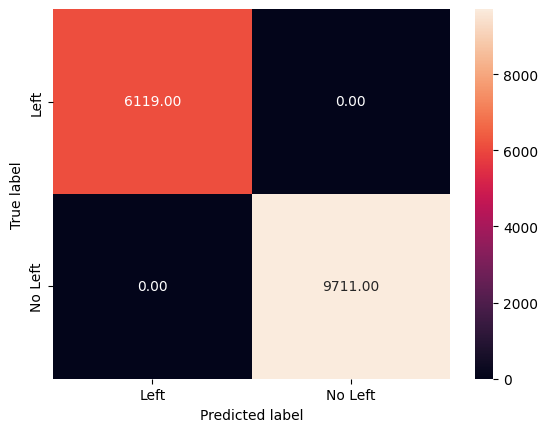

In [94]:


# Assuming tree_test_pred is a DataFrame or similar structure with 'predicted' and 'actual' attributes
tree_cm = metrics.confusion_matrix(tree_test_pred.actual, tree_test_pred.predicted, labels=[1, 0])

sns.heatmap(tree_cm, annot=True, fmt='.2f', xticklabels=["Left", "No Left"], yticklabels=["Left", "No Left"])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [44]:

import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



In [46]:
# # Ensure X_train, X_test, y_train, and y_test are numpy arrays
# X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
# X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
# y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
# y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# # Fit the model
# clf = DecisionTree(max_depth=10)
# clf.fit(X_train, y_train)

# # Make predictions
# predictions = clf.predict(X_test)

# # Calculate accuracy
# def accuracy(y_test, y_pred):
#     return np.sum(y_test == y_pred) / len(y_test)

# acc = accuracy(y_test, predictions)
# print(acc)

import numpy as np

# Ensure y_train and y_test are integer type
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# Fit the model
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

# Make predictions
predictions = clf.predict(X_test)

# Calculate accuracy
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(acc)


0.8115684882895671


In [59]:
from sklearn.svm import LinearSVC

In [60]:
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [61]:
y_pred=svm_clf.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 2])

In [62]:
accuracy_score( y_test, y_pred )

0.7944907735982967

In [63]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

model = SVC(kernel='rbf', class_weight='balanced',gamma='scale')

In [64]:
model.fit(X_train, y_train)

SVC(class_weight='balanced')

In [65]:
y_pred=model.predict(X_test)
y_pred

array([1, 1, 0, ..., 2, 0, 2])

In [66]:
accuracy_score( y_test, y_pred )

0.7063076650106459

In [73]:


class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        # init weights
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)




In [74]:
    clf = SVM()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    print("SVM classification accuracy", accuracy(y_test, predictions))

SVM classification accuracy 0.2357168204400284


In [68]:
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
y_pred=lr_clf.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 2])

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8380943931866572

In [71]:
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogisticRegression():

    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions-y)

            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db


    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

In [72]:
clf = LogisticRegression(lr=0.01)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

def accuracy(y_pred, y_test):
    return np.sum(y_pred==y_test)/len(y_test)

acc = accuracy(y_pred, y_test)
print(acc)

0.5970102909865153
